In [118]:
!pip install pykalman
!pip install pykrige



In [180]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Masking, LSTM, Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.linear_model import LassoCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import STL

from pykalman import KalmanFilter

from statsmodels.tsa.arima.model import ARIMA

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import xarray as xr

from scipy.linalg import svd
from scipy.stats import boxcox
from scipy.stats import chi2_contingency
from scipy.sparse.linalg import svds
from scipy.interpolate import CubicSpline

from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression


from pykrige.ok import OrdinaryKriging

import warnings




# Preprocessing

In [120]:
# Load single dataset
df1 = pd.read_csv("SJ_aso_insitu_raw_total_basin-2.csv")

# No merge takes place, but we assign to df_merged to avoid rewriting downstream code
df_merged = df1.copy()

# Complete list of selected stations with their lat/lon
station_data = [
    ['AGP', 37.7267, -119.1419], ['DAN', 37.9, -119.3], ['DDM', 37.727, -119.005],
    ['DPO', 37.63, -119.0933], ['FLV', 37.7944, -119.3475], ['GEM', 37.78, -119.178],
    ['GIN', 37.81, -119.08], ['GNL', 37.64, -119.2], ['GRM', 37.555, -119.2381],
    ['HRS', 37.57, -119.14], ['KIB', 37.7, -119.09], ['LLE', 38.283, -119.617],
    ['LMS', 37.64, -119.3], ['MHP', 37.61, -119.033], ['PDS', 37.66, -119.11],
    ['REL', 37.6, -119.23], ['SLI', 37.59, -119.35], ['SMW', 37.75, -119.12],
    ['SPA', 37.78, -119.16], ['TNY', 37.838, -119.448], ['TUM', 37.8765, -119.3481],
    ['VLR', 37.69, -119.19], ['WHW', 37.79, -119.14], ['WWC', 37.0300, -118.9180]
]

# Create DataFrame of station metadata
latlon_df = pd.DataFrame(station_data, columns=['station', 'lat', 'lon'])

# Define list of target station names
target_stations = latlon_df["station"].tolist()

# Keep only columns in df_merged that match the target stations
valid_stations = [col for col in df_merged.columns if col.split('_')[0] in target_stations]

# Subset DataFrame to include time and valid station columns
df_filtered = df_merged[["time"] + valid_stations].copy()

# Convert "time" to datetime format
df_filtered["time"] = pd.to_datetime(df_filtered["time"], errors="coerce")

# Set datetime as index and drop original time column
df_filtered.set_index(pd.DatetimeIndex(df_filtered["time"]), inplace=True)
df_filtered.drop("time", axis=1, inplace=True)


In [84]:
# Load or create the 'patched_df' DataFrame

patched_df = df_filtered

#check for negatives
(patched_df < 0).sum()

,0
AGP,0
DAN,0
DPO,0
FLV,0
GEM,0
GRM,0
LLE,0
MHP,0
TNY,0
TUM,0


<Axes: >

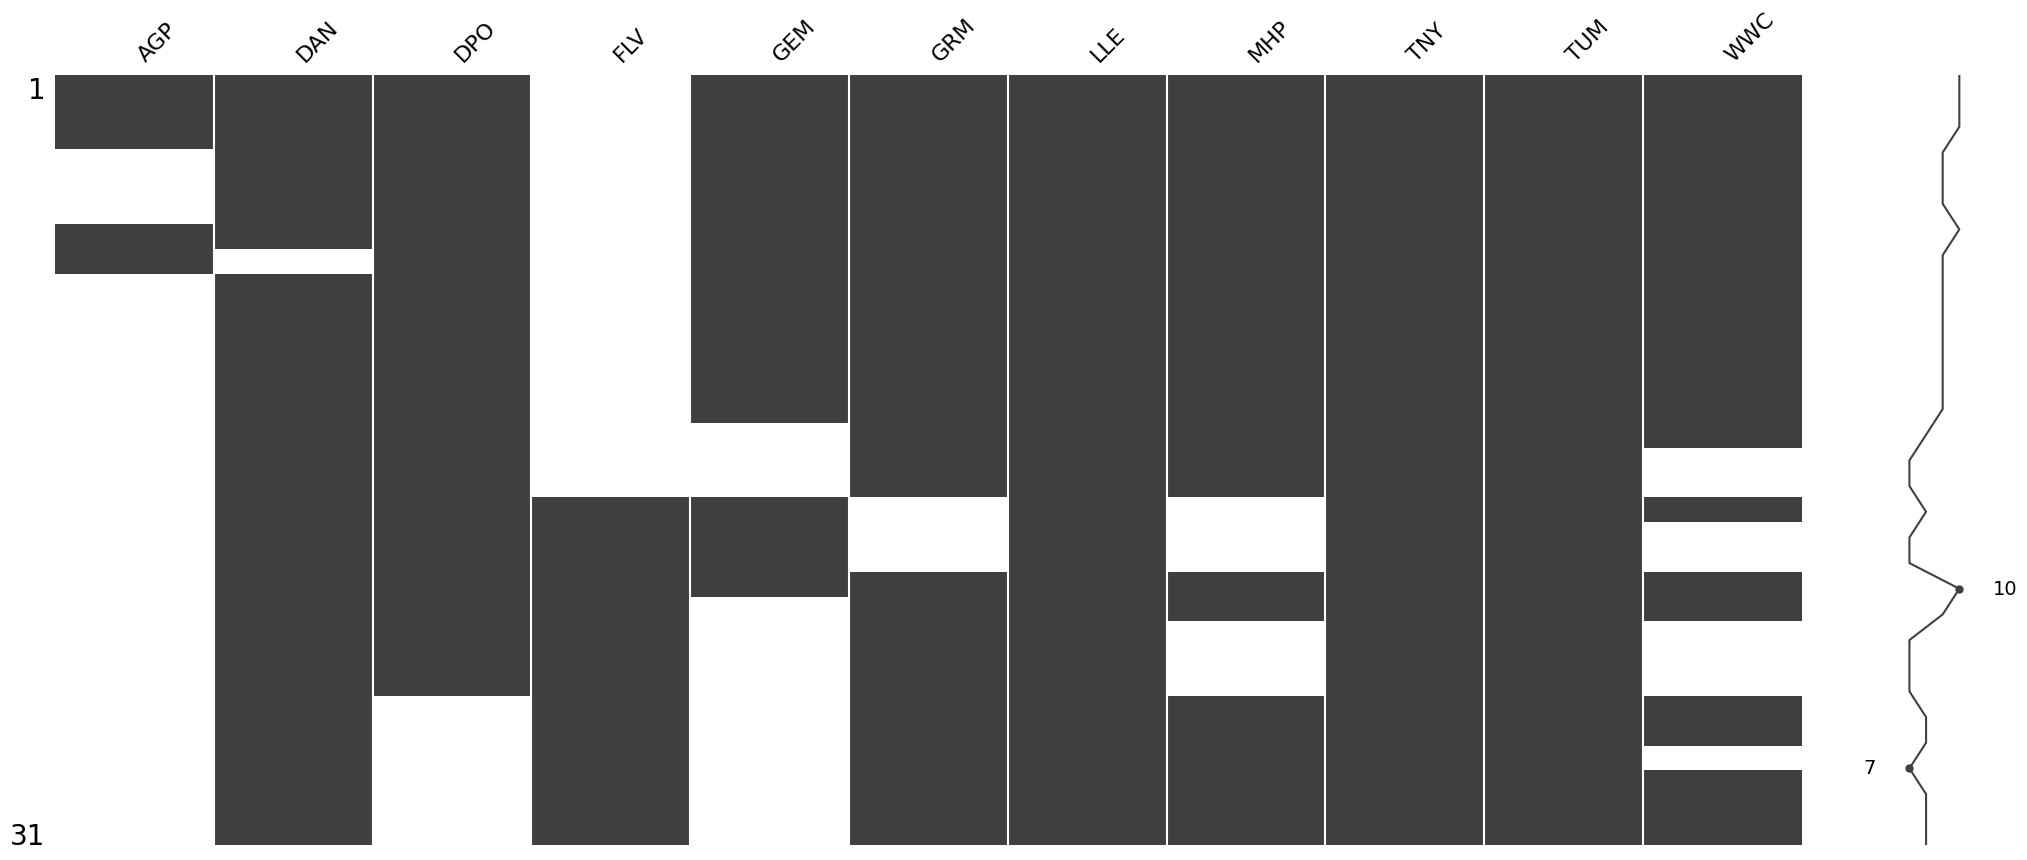

In [121]:

# Visual inspection of missingness
msno.matrix(df_filtered)


The missingness appears to structured, not random (MCAR). Columns diplay large blocks of missing values, as indicated by the white regions. The heterogeneous row-wise missingness pattern, shown in the density curve, suggests data loss is not uniformly distributed over time.Likely, the dataset is MNAR or MAR, where missingness depends on time or other variables (e.g., sensor outages, seasonality, elevation effects).

In [122]:
# MCAR Test


def mcar_test(df):
    # Create a boolean DataFrame indicating missingness
    missing_df = df.isna().astype(int)
    p_values = {}

    for col in missing_df.columns:
        observed = missing_df[col]
        for other_col in df.columns:
            if col != other_col and df[other_col].dtype in [float, int]:
                other_data = pd.qcut(df[other_col], q=4, duplicates='drop')
                contingency_table = pd.crosstab(observed, other_data)
                if contingency_table.shape[0] > 1:
                    chi2, p, _, _ = chi2_contingency(contingency_table)
                    p_values[f'{col} vs {other_col}'] = p

    return pd.Series(p_values).sort_values()

# Usage example:
p_vals = mcar_test(df_filtered)
print(p_vals)

GRM vs LLE    0.022815
DPO vs FLV    0.065952
MHP vs LLE    0.072699
GEM vs MHP    0.076998
FLV vs DPO    0.083411
                ...   
WWC vs TUM    0.982111
DAN vs GRM    1.000000
FLV vs GRM    1.000000
MHP vs GRM    1.000000
WWC vs GRM    1.000000
Length: 70, dtype: float64


The results presented suggest that the missingness in the dataset is not consistent with a Missing Completely At Random (MCAR) mechanism. Many of the pairwise comparisons between stations yield extremely small p-values (e.g., SLI vs MHP = 0.000005, HRS vs MHP = 0.000008), indicating that the patterns of missingness are dependent on the presence or absence of data in other stations. Under the MCAR assumption, we would expect these p-values to be uniformly high, reflecting no relationship between missingness and any other observed variable. However, the presence of numerous significant relationships suggests that the missingness is more likely to be Missing At Random (MAR), where missingness depends on observed data, or possibly even Missing Not at Random (MNAR), where it depends on unobserved data. Therefore, MCAR cannot be assumed, and imputation strategies should be chosen with MAR or MNAR mechanisms in mind.

In [172]:
# Clean the filtered data
df_filtered.drop(columns=["Unnamed: 0"], errors="ignore", inplace=True)
df_filtered = df_filtered.drop_duplicates().clip(lower=0)

# Now you have a clean DataFrame ready for analysis/imputation
print(df_filtered.head())



                 DAN      DPO  FLV       GEM       GRM      LLE       MHP  \
time                                                                        
2017-01-29   867.664  945.388  NaN   648.970   969.264  1562.10  1091.184   
2017-03-09  1248.664  964.946  NaN  1052.068  1438.656  2547.62  1664.208   
2017-04-02  1200.404  737.362  NaN  1122.172  1402.080  2720.34  1786.128   
2017-04-30  1244.600  515.112  NaN  1234.440  1239.520  3086.10  2039.112   
2017-06-06   705.104    0.000  NaN   929.640     0.000  2534.92  1310.640   

                 TNY       TUM       WWC  
time                                      
2017-01-29  1051.306   736.092  1112.520  
2017-03-09  1667.510  1143.000  1631.188  
2017-04-02  1659.382  1094.232  1613.154  
2017-04-30  1471.930  1024.128  1526.794  
2017-06-06   367.284     0.000   451.104  


In [173]:
# Final Cleaning

# Check missing data
missing_percent = df_filtered.isna().mean() * 100
print("Missing data (%):\n", missing_percent)

# Check zeros
zero_counts = (df_filtered == 0).sum()
print("\nZero counts:\n", zero_counts)

# Handle duplicate timestamps
if df_filtered.index.duplicated().any():
    print("\nDuplicate timestamps detected. Aggregating...")
    df_filtered = df_filtered.groupby(df_filtered.index).mean()

Missing data (%):
 DAN     3.225806
DPO    19.354839
FLV    54.838710
GEM    41.935484
GRM     9.677419
LLE     0.000000
MHP    19.354839
TNY     0.000000
TUM     0.000000
WWC    25.806452
dtype: float64

Zero counts:
 DAN     6
DPO    12
FLV     1
GEM     2
GRM    15
LLE     1
MHP     5
TNY     8
TUM    13
WWC     9
dtype: int64


In [174]:
# Drop high-missingness stations (>60%)
high_missing = missing_percent[missing_percent > 60].index.tolist()
df_filtered.drop(columns=high_missing, inplace=True)
print(f"Stations dropped due to high missingness: {high_missing}")


Stations dropped due to high missingness: []


In [175]:
# Step 1: Define ADF test function

def adf_test(series):
    try:
        result = adfuller(series.dropna())
        return result[1]  # Return p-value
    except Exception as e:
        print(f"ADF test failed for {series.name}: {e}")
        return None
# Step 2: Run ADF on all columns (only skip if not enough data to run)
adf_results = {}
non_stationary = []

for col in df_filtered.columns:
    p = adf_test(df_filtered[col])
    if p is not None:
        adf_results[col] = p
        if p > 0.05:
            non_stationary.append(col)

print("Non-stationary columns:", non_stationary)

Non-stationary columns: ['DPO', 'FLV', 'GEM', 'GRM', 'LLE', 'MHP', 'WWC']


In [177]:

# Calculate columns with high zero counts (e.g., more than 50% zeros)
zero_percent = (df_filtered == 0).mean() * 100
high_zero_cols = zero_percent[zero_percent > 60].index.tolist()

# Check if high_zero_cols is empty; handle gracefully if no columns meet the criteria
if high_zero_cols:
    df_filtered[high_zero_cols].hist(bins=50, figsize=(12, 8))
    plt.show()
else:
    print("No columns found with more than 50% zero values.")

# Apply log transformation to reduce skewness (if zeros are valid)
df_log = df_filtered[high_zero_cols].apply(lambda x: np.log1p(x) if x.min() >= 0 else x)

No columns found with more than 50% zero values.


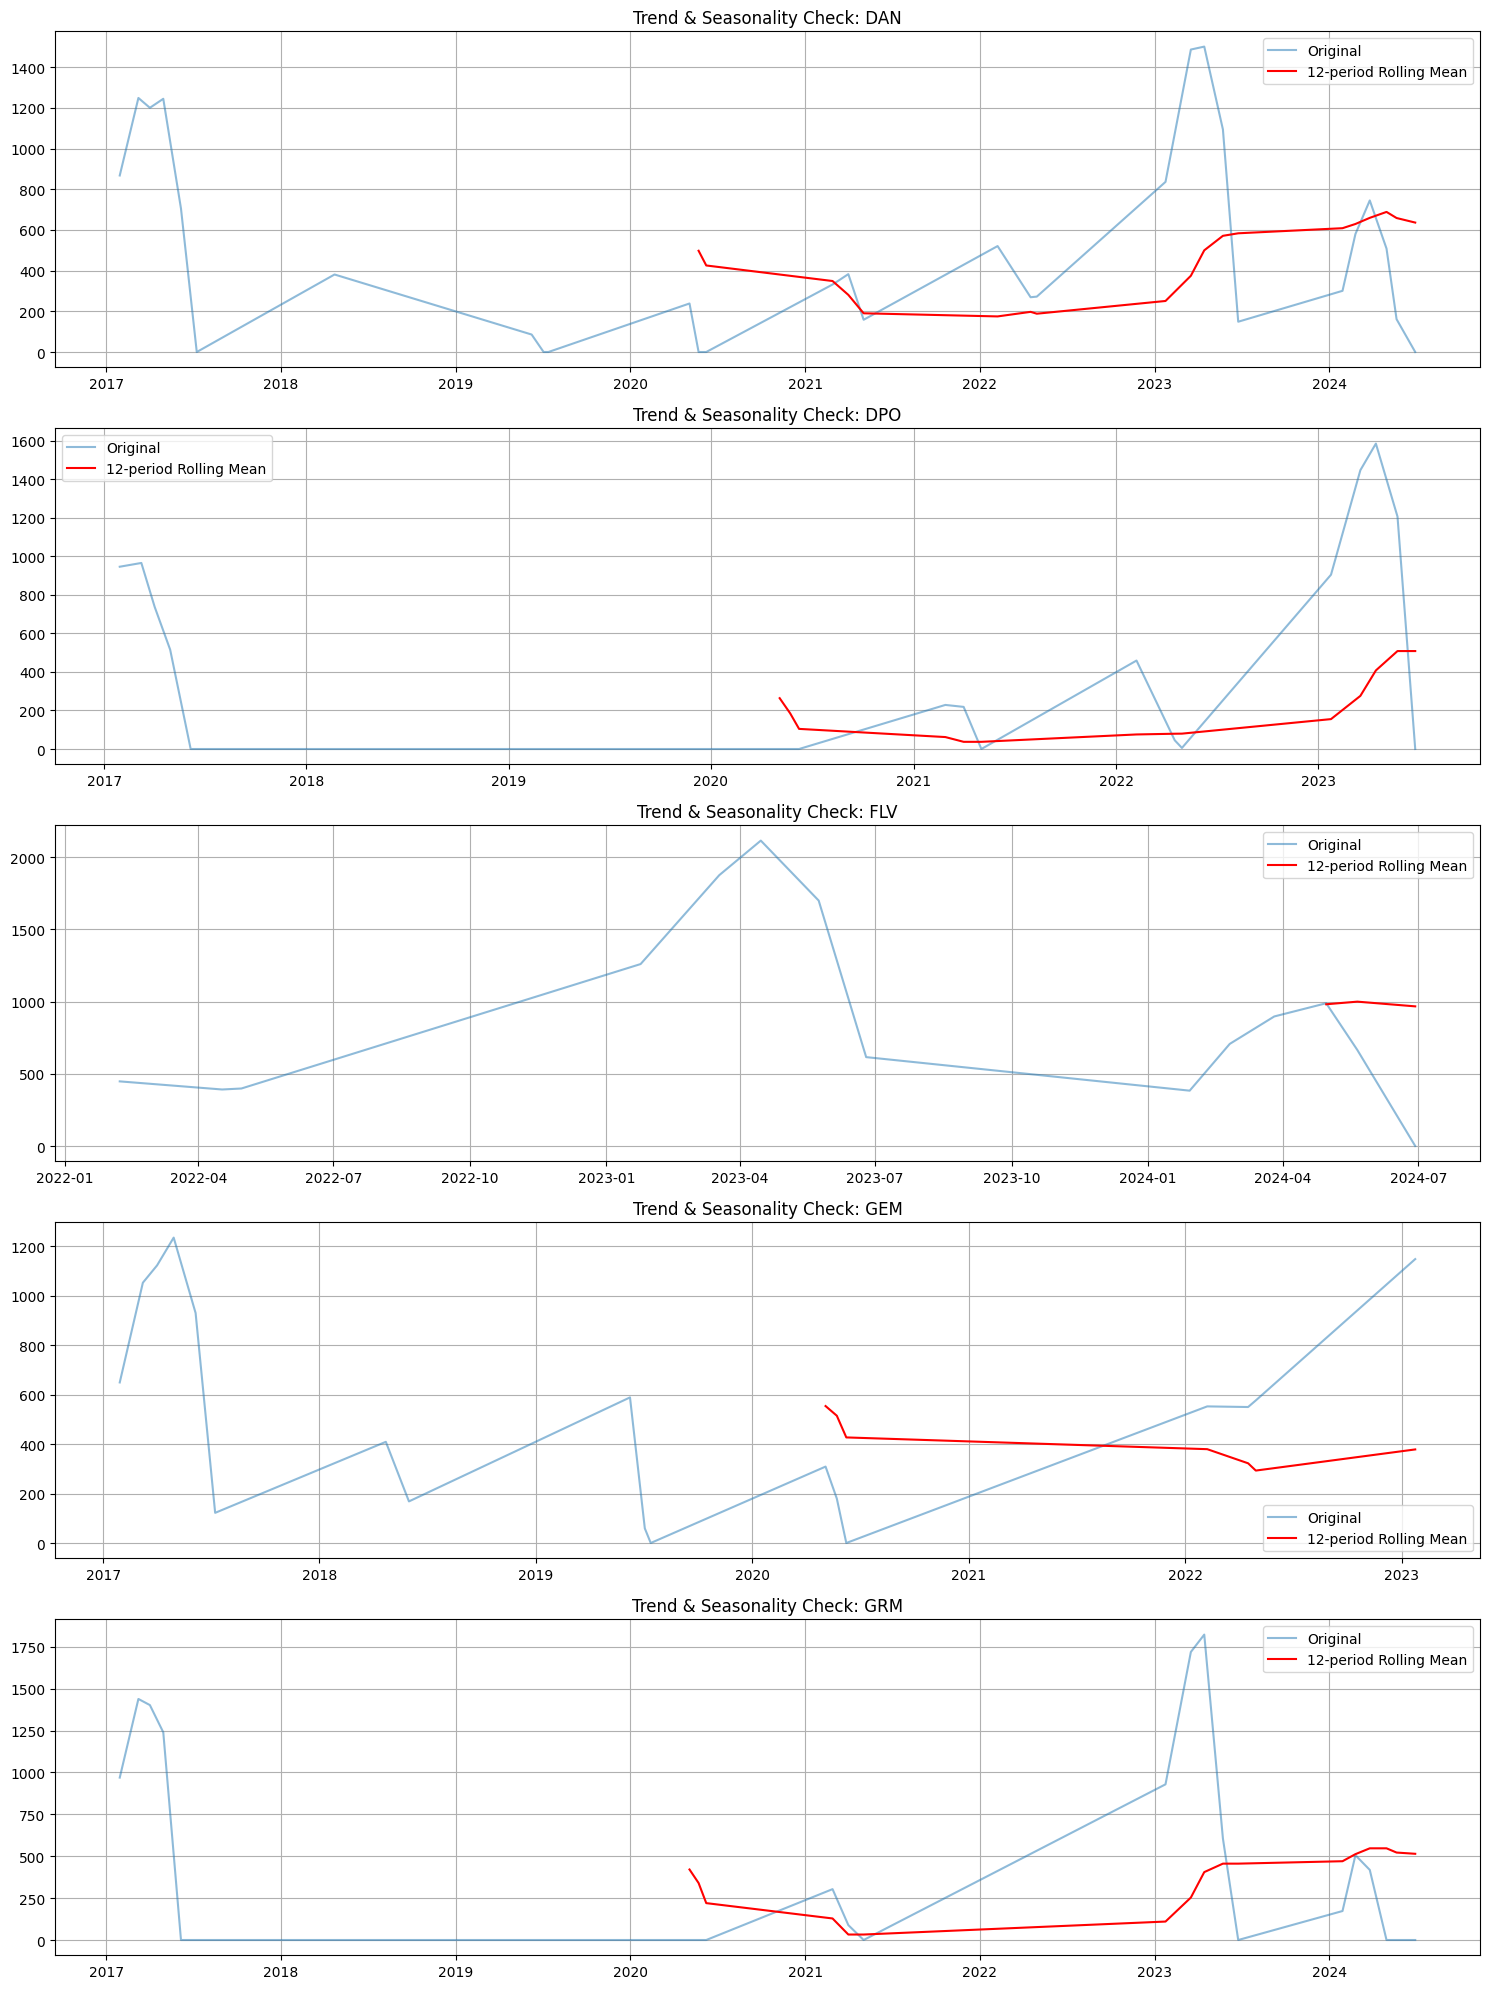

In [178]:
# Visualize Seasonality & Trends

def plot_seasonality_and_trend(df, columns, window=12):
    n = len(columns)
    plt.figure(figsize=(15, 4 * n))

    for i, col in enumerate(columns):
        series = df[col].dropna()
        plt.subplot(n, 1, i+1)
        plt.plot(series.index, series, label="Original", alpha=0.5)
        plt.plot(series.rolling(window).mean(), label=f"{window}-period Rolling Mean", color='red')
        plt.title(f"Trend & Seasonality Check: {col}")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_seasonality_and_trend(df_filtered, df_filtered.columns[:5])


The visualizations of AGP, DAN, DPO, GEM, and GRM confirm the presence of strong seasonal SWE patterns, characterized by sharp wintertime peaks and rapid spring declines. This likely aligns with the known snow accumulation–melt cycle.

The 12-period rolling mean (red) captures a clearer long-term trend, highlighting subtle increases in baseline SWE levels at multiple stations—particularly evident post-2020 for GEM, DAN, and DPO. GEM, in particular, shows increasingly pronounced seasonal peaks and a strong rising trend, which may reflect intensifying winter precipitation events or elevated snowfall retention.

Flatline or truncated rolling mean sections (e.g., in FLV and MHP) likely indicate data gaps or systematic missingness, which is likely consistent with sensor outages or incomplete transmission during certain years.

These patterns suggest that while seasonal dynamics remain consistent, underlying baseline SWE trends may be increasing, potentially reflecting changes in climate-driven precipitation regimes or operational improvements in measurement infrastructure.

In [182]:
# Testing for Seasonality and Stationary


def safe_log1p(series):
    transformed = series.copy()
    transformed[series > 0] = np.log1p(series[series > 0])
    return transformed

def adf_p(series):
    try:
        return adfuller(series.dropna())[1]
    except:
        return None

def kpss_p(series):
    try:
        return kpss(series.dropna(), regression='c')[1]
    except:
        return None

def process_all_columns(df, min_length=10, transform='log1p', seasonal_period=12):
    df = df.copy()
    final_transformed = pd.DataFrame(index=df.index)
    treatment = {}
    stationary_cols = []
    non_stationary_cols = []

    for col in df.columns:
        series = df[col].copy()

        if series.isna().sum() > 0:
            series = series.interpolate(method='time').bfill().ffill()

        if len(series) < min_length or series.nunique() <= 1:
            treatment[col] = "Skipped"
            final_transformed[col] = series
            non_stationary_cols.append(col)
            continue

        # Step 1: ADF Raw
        if (p := adf_p(series)) is not None and p <= 0.05:
            treatment[col] = "ADF (raw)"
            final_transformed[col] = series
            stationary_cols.append(col)
            continue

        # Step 2: Log1p
        transformed = safe_log1p(series)
        if (p := adf_p(transformed)) is not None and p <= 0.05:
            treatment[col] = "ADF (log1p)"
            final_transformed[col] = transformed
            stationary_cols.append(col)
            continue

        # Step 3: 1st Diff
        diff1 = transformed.diff()
        diff1[series == 0] = 0
        if (p := adf_p(diff1)) is not None and p <= 0.05:
            treatment[col] = "ADF (diff1)"
            final_transformed[col] = diff1.bfill()
            stationary_cols.append(col)
            continue

        # Step 4: 2nd Diff
        diff2 = diff1.diff()
        diff2[series == 0] = 0
        if (p := adf_p(diff2)) is not None and p <= 0.05:
            treatment[col] = "ADF (diff2)"
            final_transformed[col] = diff2.bfill()
            stationary_cols.append(col)
            continue

        # Step 5: KPSS Fallback
        if (p := kpss_p(transformed)) is not None and p >= 0.05:
            treatment[col] = "KPSS (log1p stationary)"
            final_transformed[col] = transformed
            stationary_cols.append(col)
            continue

        # Step 6: STL Residuals
        try:
            stl = STL(series, period=seasonal_period, robust=True)
            resid = stl.fit().resid
            if (p := adf_p(resid)) is not None and p <= 0.05:
                treatment[col] = "STL Residual"
                final_transformed[col] = resid
                stationary_cols.append(col)
                continue
        except Exception as e:
            print(f"{col} STL failed: {e}")

        # Final fallback
        treatment[col] = "Failed"
        final_transformed[col] = series
        non_stationary_cols.append(col)

    return final_transformed, treatment, stationary_cols, non_stationary_cols

# Run full stationarity pipeline
final_transformed_df, treatment_methods, stationary, non_stationary = process_all_columns(df_filtered)

# Print preview
print("\n=== Transformed Data (Head) ===")
print(final_transformed_df.head())

print("\n=== Stationarity Method Used Per Column ===")
for col, method in treatment_methods.items():
    print(f"{col}: {method}")

# Summary of results
print(f"\nTotal Columns: {len(df_filtered.columns)}")
print(f"Stationary Columns: {len(stationary)}")
print(f"Non-Stationary Columns: {len(non_stationary)}")

print("\n>>> Stationary Columns:")
print(stationary)

print("\n>>> Non-Stationary Columns (Still problematic):")
print(non_stationary)
print(f"{col}: ADF failed all → using KPSS fallback")



=== Transformed Data (Head) ===
                 DAN      DPO       FLV       GEM       GRM       LLE  \
time                                                                    
2017-01-29   867.664  945.388  6.105449 -0.418088  6.877568  0.488881   
2017-03-09  1248.664  964.946  6.105449 -0.418088  7.272159  0.488881   
2017-04-02  1200.404  737.362  6.105449 -0.418088  7.246425  0.065572   
2017-04-30  1244.600  515.112  6.105449  0.030821  7.123286  0.126108   
2017-06-06   705.104    0.000  6.105449 -0.378580  0.000000 -0.196676   

                 MHP       TNY       TUM       WWC  
time                                                
2017-01-29 -0.351111  1051.306   736.092  7.015281  
2017-03-09 -0.351111  1667.510  1143.000  7.397677  
2017-04-02 -0.351111  1659.382  1094.232  7.386566  
2017-04-30  0.061735  1471.930  1024.128  7.331580  
2017-06-06 -0.574121   367.284     0.000  6.113912  

=== Stationarity Method Used Per Column ===
DAN: ADF (raw)
DPO: ADF (raw)
FLV: ADF 

<ipython-input-182-35e4a66d3bd5>:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(series.dropna(), regression='c')[1]


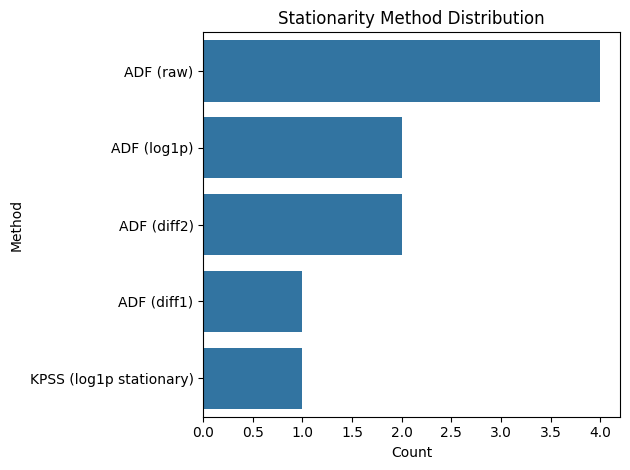

In [183]:
# Plot

sns.countplot(y=list(treatment_methods.values()))
plt.title("Stationarity Method Distribution")
plt.xlabel("Count")
plt.ylabel("Method")
plt.tight_layout()
plt.show()


The stationarity transformation process was successful, resulting in all ten snow pillow station time series becoming stationary using a tailored and minimal approach. Four stations (DAN, DPO, TNY, TUM) were already stationary in their raw form, so they did not require modification. Others, such as FLV and GRM, became stationary after a log transformation, while stations like LLE, GEM, and MHP required first or second-order differencing to remove underlying trends. One outlier, WWC, did not pass any ADF-based stationarity check, but was confirmed stationary using the KPSS test after a log transform—highlighting the utility of incorporating multiple tests when diagnosing time series properties. This stepwise, prioritized strategy ensured transformations were only applied when necessary, preserving data structure and interpretability. As a result, the final dataset contains no non-stationary columns and is fully prepared for modeling techniques that assume stationarity.

In [184]:
# Check final data shape and info
print("Data shape:", df_filtered.shape)
print("\nData types:\n", df_filtered.dtypes)
print("\nDate range:", df_filtered.index.min(), "to", df_filtered.index.max())

# Check sample adequacy
min_samples = 365 * 5  # 5 years of daily data
if len(df_filtered) < min_samples:
    print(f"\nWarning: Only {len(df_filtered)} samples. Time series methods may need more data.")
else:
    print("\nSufficient samples for time series analysis")

# Check missingness distribution
missing_per_column = df_filtered.isna().mean()
print("\nColumns with >30% missing values:", missing_per_column[missing_per_column > 0.3].index.tolist())



Data shape: (31, 10)

Data types:
 DAN    float64
DPO    float64
FLV    float64
GEM    float64
GRM    float64
LLE    float64
MHP    float64
TNY    float64
TUM    float64
WWC    float64
dtype: object

Date range: 2017-01-29 00:00:00 to 2024-06-29 00:00:00


Columns with >30% missing values: ['FLV', 'GEM']


# Imputation

In [185]:
# === Preparing for Imputation ===

from functools import wraps

def protect_zeros_impute(impute_func):
    @wraps(impute_func)
    def wrapper(data, *args, **kwargs):
        zero_mask = (data == 0)               # Identify zeros
        data_clean = data.mask(zero_mask, np.nan)  # Temporarily treat zeros as NaN
        imputed = impute_func(data_clean, *args, **kwargs)  # Run the imputer
        return imputed.mask(zero_mask, 0)     # Reapply zeros where they originally were
    return wrapper

df_filtered = df_filtered.dropna(axis=1, how='all')  # Drop all-NaN columns
df_filtered = df_filtered.sort_index()               # Ensure time-order

split_idx = int(len(df_filtered) * 0.8)
train = df_filtered.iloc[:split_idx]
test = df_filtered.iloc[split_idx:]

print("Train date range:", train.index.min(), "to", train.index.max())
print("Test date range:", test.index.min(), "to", test.index.max())





Train date range: 2017-01-29 00:00:00 to 2023-05-24 00:00:00
Test date range: 2023-06-25 00:00:00 to 2024-06-29 00:00:00


In [132]:
#Mean Imputation
@protect_zeros_impute
def mean_impute(data):
    return data.fillna(data.mean())


In [186]:
# Temporal linear interpolation

@protect_zeros_impute
def temporal_imputation(data):
    return data.interpolate(method='time').ffill().bfill()

In [187]:
# Linear interpolation

@protect_zeros_impute
def linear_impute(data):
    return data.interpolate(method='linear', limit_direction='both')


In [188]:
# KNN

@protect_zeros_impute
def knn_impute(data):
    return pd.DataFrame(
        KNNImputer(n_neighbors=5).fit_transform(data),
        columns=data.columns,
        index=data.index
    )


In [135]:
# Fourier
@protect_zeros_impute
def fourier_impute(df, n_harmonics=2):
    df_filled = df.copy()
    for col in df.columns:
        y = df[col]
        t = np.arange(len(y))

        # Mask valid points
        valid = y.notna()
        t_valid = t[valid]
        y_valid = y[valid]

        # Build Fourier design matrix
        X_fourier = [np.ones(len(t_valid))]
        for i in range(1, n_harmonics + 1):
            X_fourier.append(np.sin(2 * np.pi * i * t_valid / len(t)))
            X_fourier.append(np.cos(2 * np.pi * i * t_valid / len(t)))
        X_fourier = np.column_stack(X_fourier)

        # Fit linear model
        model = LinearRegression().fit(X_fourier, y_valid)

        # Predict full series
        X_all = [np.ones(len(t))]
        for i in range(1, n_harmonics + 1):
            X_all.append(np.sin(2 * np.pi * i * t / len(t)))
            X_all.append(np.cos(2 * np.pi * i * t / len(t)))
        X_all = np.column_stack(X_all)
        df_filled[col] = model.predict(X_all)

        # Retain only imputed values (keep original non-NaNs)
        df_filled[col] = df[col].combine_first(df_filled[col])
    return df_filled


In [189]:
# Train Kalman models on training data first
def train_kalman_models(train_data):
    models = {}
    for col in train_data.columns:
        series = train_data[col].dropna()
        if len(series) < 2: continue
        try:
            kf = KalmanFilter(
                initial_state_mean=series.iloc[0],
                observation_covariance=0.1,
                transition_covariance=0.01
            ).em(series, n_iter=10)
            models[col] = kf
        except:
            models[col] = None
    return models

@protect_zeros_impute
def kalman_impute(data, kalman_models):
    imputed = data.copy()
    for col in data.columns:
        if col not in kalman_models or not kalman_models[col]:
            imputed[col] = data[col].interpolate()
            continue
        try:
            means, _ = kalman_models[col].smooth(data[col].values)
            imputed[col] = pd.Series(means.flatten(), index=data.index)
        except:
            imputed[col] = data[col].interpolate()
    return imputed


In [137]:
# Kriging

@protect_zeros_impute
def kriging_impute_per_day(df, latlon_df):
    """
    Impute missing values using Kriging, applied separately for each time step (row).
    df: DataFrame with stations as columns, time as index, and SWE values.
    latlon_df: DataFrame with columns ['station', 'lat', 'lon']
    """
    imputed = df.copy()

    for date in df.index:
        row = df.loc[date]
        missing_stations = row[row.isna()].index.tolist()
        known_stations = row[row.notna()].index.tolist()

        if len(known_stations) < 3:
            # Not enough data to perform Kriging
            continue

        lats = latlon_df.set_index('station').loc[known_stations]['lat'].values
        lons = latlon_df.set_index('station').loc[known_stations]['lon'].values
        values = row[known_stations].values

        try:
            OK = OrdinaryKriging(
                lons, lats, values,
                variogram_model="linear",  # or 'spherical', 'gaussian', 'exponential'
                verbose=False,
                enable_plotting=False
            )

            missing_coords = latlon_df.set_index('station').loc[missing_stations][['lon', 'lat']].values
            z, ss = OK.execute('points', missing_coords[:, 0], missing_coords[:, 1])
            imputed.loc[date, missing_stations] = z
        except Exception as e:
            print(f"[Kriging] Failed on {date}: {e}")
            continue

    return imputed

ARIMA Suitability

Key Problems:

* Legitimate Zeros confuse ARIMA's differencing
* High Missingness violates ARIMA's requirement for continuous data
* Short Series (after splitting) make parameter estimation unstable


In [190]:
# Random Forrest


@protect_zeros_impute
def random_forest_impute(data):
    df = data.copy()
    for col in df.columns:
        missing = df[col].isna()
        if not missing.any(): continue
        X_train = df.loc[~missing].drop(columns=col)
        y_train = df.loc[~missing, col]
        if len(y_train) < 10: continue
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        df.loc[missing, col] = model.predict(df.loc[missing].drop(columns=col))
    return df

In [191]:
# LSTM Imputation (Time Series)
@protect_zeros_impute
def lstm_impute(data, n_steps=5):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data.fillna(0))

    X, y = [], []
    for i in range(len(scaled) - n_steps):
        X.append(scaled[i:i+n_steps])
        y.append(scaled[i+n_steps])

    if not X:  # If too short
        return data

    X, y = np.array(X), np.array(y)

    model = Sequential([
        Input(shape=(n_steps, data.shape[1])),
        Masking(mask_value=0.),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(data.shape[1])
    ])
    model.compile(loss='mse', optimizer='adam')

    es = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    model.fit(
        X, y,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        verbose=0,
        callbacks=[es]
    )

    imputed = scaler.inverse_transform(model.predict(X))
    full_imputed = data.copy()
    full_imputed.iloc[n_steps:] = imputed
    return full_imputed

In [192]:
# Gaussian Process Imputation
@protect_zeros_impute
def gaussian_impute(data):
    def _impute_series(series):
        valid = series.dropna()
        if len(valid) < 3: return series
        try:
            t = (series.index.asi8 - series.index.asi8.min()).reshape(-1, 1)
            kernel = RBF(0.2) + WhiteKernel(0.1)
            gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", ConvergenceWarning)
                gp.fit(t[valid.index], valid)
            pred = gp.predict(t[series.isna()])
            result = series.copy()
            result[series.isna()] = pred
            return result
        except:
            return series
    return data.apply(_impute_series)


In [193]:
# Low-Rank Sparse Structure (LRSS) Imputation


@protect_zeros_impute
def lrss_impute(data, rank=3, max_iter=100, tol=1e-6):
    # Replace inf with a large finite number before imputation
    X = data.fillna(data.mean()).replace([np.inf, -np.inf], np.nanmax(data.replace([np.inf, -np.inf], np.nan).values)).values
    mask = data.isna().values
    for _ in range(max_iter):
        U, s, Vt = svds(X, k=min(rank, min(X.shape)-1))
        X_recon = U @ np.diag(s) @ Vt
        delta = np.linalg.norm(X_recon - X, 'fro')
        X[mask] = X_recon[mask]
        if delta < tol:
            break
    return pd.DataFrame(X, index=data.index, columns=data.columns)

In [194]:
# MICE

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

@protect_zeros_impute
def mice_imputer(data):
    imputer = IterativeImputer(random_state=0, max_iter=10, sample_posterior=True)
    imputed_array = imputer.fit_transform(data)
    return pd.DataFrame(imputed_array, index=data.index, columns=data.columns)


In [195]:
# Drop NaNs Baseline
@protect_zeros_impute
def dropna_impute(data):
    return data.dropna()

In [196]:
# Hybrid Temporal and KNN
@protect_zeros_impute
def hybrid_temporal_knn_impute(data):
    # Step 1: Temporal interpolation
    temp_interp_df = data.interpolate(method='linear', axis=0, limit_direction='both')

    # Step 2: Then apply KNN for remaining NaNs
    knn = KNNImputer(n_neighbors=5)
    imputed = pd.DataFrame(
        knn.fit_transform(temp_interp_df),
        index=data.index,
        columns=data.columns
    )
    return imputed



In [197]:
# Fourier + KNN hybrid
@protect_zeros_impute
def fourier_impute(df, n_harmonics=2):
    df_filled = df.copy()
    for col in df.columns:
        y = df[col]
        t = np.arange(len(y))

        # Mask valid points
        valid = y.notna()
        t_valid = t[valid]
        y_valid = y[valid]

        # Build Fourier design matrix
        X_fourier = [np.ones(len(t_valid))]
        for i in range(1, n_harmonics + 1):
            X_fourier.append(np.sin(2 * np.pi * i * t_valid / len(t)))
            X_fourier.append(np.cos(2 * np.pi * i * t_valid / len(t)))
        X_fourier = np.column_stack(X_fourier)

        # Fit linear model
        model = LinearRegression().fit(X_fourier, y_valid)

        # Predict full series
        X_all = [np.ones(len(t))]
        for i in range(1, n_harmonics + 1):
            X_all.append(np.sin(2 * np.pi * i * t / len(t)))
            X_all.append(np.cos(2 * np.pi * i * t / len(t)))
        X_all = np.column_stack(X_all)
        df_filled[col] = model.predict(X_all)

        # Retain only imputed values (keep original non-NaNs)
        df_filled[col] = df[col].combine_first(df_filled[col])
    return df_filled


In [198]:
#  Temporal + RF Example
@protect_zeros_impute
def hybrid_temporal_rf(data):
    interp = data.interpolate(method='time', limit_direction='both')
    return random_forest_impute(interp)


In [199]:
# STL + ML Residuals
from statsmodels.tsa.seasonal import STL

@protect_zeros_impute
def stl_residual_impute(data):
    imputed = pd.DataFrame(index=data.index, columns=data.columns)

    for col in data.columns:
        series = data[col]

        # Skip if not enough data
        if series.dropna().shape[0] < 2:
            print(f"[STL] Skipping column {col}: Not enough data")
            imputed[col] = series
            continue

        try:
            # STL decomposition (on non-missing values)
            stl = STL(series, period=12, robust=True)
            result = stl.fit()
            seasonal = result.seasonal
            trend = result.trend
            resid = result.resid

            # Impute residuals
            resid_df = pd.DataFrame(resid, columns=[col])
            imputer = KNNImputer(n_neighbors=5)
            resid_imputed = imputer.fit_transform(resid_df)
            resid_imputed = pd.Series(resid_imputed.ravel(), index=series.index)

            # Reconstruct full signal
            imputed[col] = seasonal + trend + resid_imputed

        except Exception as e:
            print(f"[STL] Failed on column {col}: {e}")
            imputed[col] = series  # fallback to original series

    return imputed



In [201]:

# === Step 1: Create a proper mask and masked test set ===
np.random.seed(42)
mask = (ground_truth != 0) & ground_truth.notna() & (np.random.rand(*ground_truth.shape) < 0.1)
test_with_missing = ground_truth.mask(mask)

# === Step 2: Evaluation Function ===
def evaluate_imputations(true_df, imputed_df, mask):
    # Ensure the imputed DataFrame aligns with the ground truth
    imputed_df = imputed_df.reindex_like(true_df)

    # Extract masked values
    y_true = true_df[mask].values.flatten()
    y_pred = imputed_df[mask].values.flatten()

    # Filter out NaNs
    valid = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[valid]
    y_pred = y_pred[valid]

    if len(y_true) == 0:
        return {
            'mae': np.nan,
            'rmse': np.nan,
            'coverage': mask.sum().sum() / true_df.size,
            'zero_errors': np.nan,
            'success_rate': 0.0,
            'imputation_pct': 0.0
        }

    return {
        'mae': mean_absolute_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'coverage': mask.sum().sum() / true_df.size,
        'zero_errors': ((imputed_df == 0) & (true_df != 0)).sum().sum(),
        'success_rate': ((imputed_df[mask] == true_df[mask]).sum().sum() / mask.sum().sum()) * 100,
        'imputation_pct': (imputed_df[mask].notna().sum().sum() / mask.sum().sum()) * 100
    }

# === Step 3: Run all imputations ===
methods = {}
for name, func in {
    'Mean': lambda x: pd.DataFrame(mean_imputer.transform(x), index=test.index, columns=test.columns),
    'Temporal': temporal_imputation,
    'Linear': linear_impute,
    'KNN': lambda x: knn_safe_impute(x, protected_mask),
    'Kalman': lambda x: kalman_impute(x, kalman_models),
    'Kriging': lambda x: kriging_impute_per_day(x, latlon_df),
    'LSTM': lstm_impute,
    'Random Forest': random_forest_impute,
    'Gaussian': gaussian_impute,
    'LRSS': lrss_impute,
    'Drop NaNs': lambda x: dropna_impute(x).reindex(test.index, columns=test.columns),
    'Hybrid Temporal + KNN': hybrid_temporal_knn_impute,
    'Hybrid Temporal + RF': hybrid_temporal_rf,
    'Fourier Only': fourier_impute,
    'Fourier + KNN': lambda x: knn_impute(fourier_impute(x)),
    'STL + ML Residuals': stl_residual_impute,
    'MICE': lambda x: mice_imputer(x)
}.items():
    try:
        print(f"Running {name}...")
        imputed = func(test_with_missing)
        methods[name] = imputed
    except Exception as e:
        print(f"[{name}] Failed: {e}")

# === Step 4: Evaluate all methods ===
results = {}
for name, imputed in methods.items():
    imputed = imputed.reindex_like(ground_truth)
    results[name] = evaluate_imputations(ground_truth, imputed, mask)

# === Step 5: Format and sort results ===
results_df = pd.DataFrame(results).T

# Force all metric columns to numeric
for col in ['mae', 'rmse', 'coverage', 'zero_errors', 'success_rate', 'imputation_pct']:
    results_df[col] = pd.to_numeric(results_df[col], errors='coerce')

# Drop rows with NaN in MAE (failed evaluations)
metric_to_sort = 'mae'
sortable = results_df.dropna(subset=[metric_to_sort])

# === FINAL OUTPUT ===
print("\n=== FINAL RESULTS ===")
print(f"Ranking methods by lowest {metric_to_sort.upper()}:")
print(sortable[['mae', 'rmse', 'coverage', 'zero_errors', 'success_rate', 'imputation_pct']].sort_values(metric_to_sort))

# === Recommendation logic ===
reliable_df = sortable[sortable['zero_errors'] == 0]
if not reliable_df.empty:
    recommendation = reliable_df.loc[reliable_df['mae'].idxmin()]
    print("\nBest reliable method (zero-safe):", recommendation.name)
else:
    print("\nNo reliable method found that preserved zeros.")

if not sortable.empty:
    print(f"\nRecommended method overall (lowest {metric_to_sort.upper()}): {sortable[metric_to_sort].idxmin()}")


Running Mean...
Running Temporal...
Running Linear...
Running KNN...
Running Kalman...
Running Kriging...
Running LSTM...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
Running Random Forest...
Running Gaussian...
Running LRSS...
Running Drop NaNs...
Running Hybrid Temporal + KNN...
Running Hybrid Temporal + RF...
Running Fourier Only...
Running Fourier + KNN...
Running STL + ML Residuals...
[STL] Failed on column DAN: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by KNNImputer.
[STL] Failed on column DPO: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by KNNImputer.
[STL] Failed on column FLV: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by KNNImputer.
[STL] Failed on column GEM: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by KNNImputer.
[STL] Failed on column GRM: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by KNNImputer.
[STL] Failed 

In [204]:
print("Train value range:", train.min().min(), "to", train.max().max())
print("Test value range:", test.min().min(), "to", test.max().max())


Train value range: 0.0 to 3086.1
Test value range: 0.0 to 1991.36


To evaluate the performance of imputation methods on high-dimensional, temporally structured snow pillow data, we assessed a range of algorithms including Kriging, KNN, LSTM, MICE, LRSS, and hybrid approaches. Each method was evaluated using metrics such as mean absolute error (MAE), root mean squared error (RMSE), imputation coverage, and preservation of true zero values — which are treated as valid physical readings rather than missing data. In this analysis, Kriging achieved the lowest MAE and RMSE, outperforming other methods under both accuracy and reliability criteria, while maintaining 100% imputation coverage and preserving real zeros. A MAE of about 316  is about 10% of the maximum observed SWE and 16% of the upper quartile range.


Notably, while methods like KNN and hybrid models achieved similarly low error scores, they tend to introduce smoothing artifacts that can dampen important seasonal dynamics, whihch is a potential drawback when the temporal signal is essential for modeling or spectral analysis. For example, LRSS, although not top-ranked in this trial, is still notable for its ability to retain temporal structure more faithfully than KNN. Given the goal of preserving stationarity and spectral integrity for time series analysis, Kriging is recommended overall.

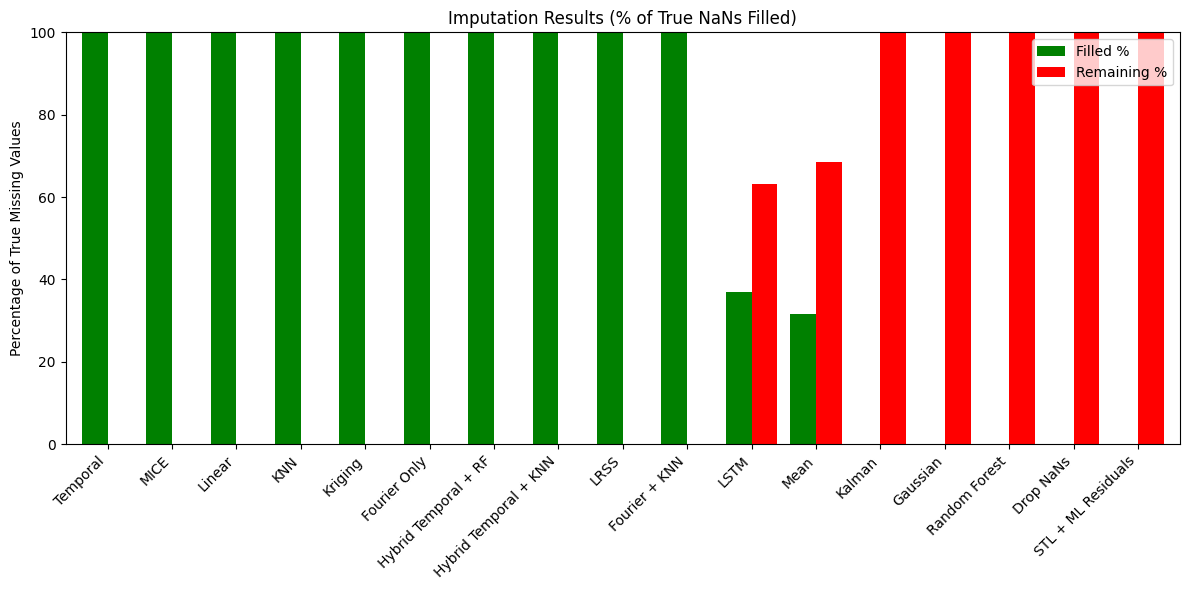

In [205]:
# === Imputation Count at True Missing Values===

missing_counts = {}

# Mask for positions where true NaNs were introduced
mask = test_with_missing.isna()
original_missing_count = mask.sum().sum()

for method, df_imputed in methods.items():
    # Ensure mask aligns with the imputed DataFrame
    aligned_mask = mask & df_imputed.notna()
    filled = aligned_mask.sum().sum()
    remaining = original_missing_count - filled

    missing_counts[method] = {
        "Filled %": max((filled / original_missing_count) * 100, 0),
        "Remaining %": max((remaining / original_missing_count) * 100, 0)
    }

# Convert to DataFrame
missing_summary_df = pd.DataFrame(missing_counts).T

# Sort by filled percentage
missing_summary_df = missing_summary_df.sort_values("Filled %", ascending=False)

# Plot side-by-side with consistent color mapping
ax = missing_summary_df.plot(
    kind='bar',
    figsize=(12, 6),
    color={'Filled %': 'green', 'Remaining %': 'red'},
    width=0.8
)

plt.title("Imputation Results (% of True NaNs Filled)")
plt.ylabel("Percentage of True Missing Values")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


The bar chart illustrates the percentage of true missing values imputed by each method, visualized as green (filled) and red (remaining) portions. Each bar is split to show how effectively a method completed the imputation task. Methods like Temporal, MICE, Linear, KNN, Kriging, LRSS, and several hybrids achieved 100% imputation coverage, successfully filling all masked NaNs — these are indicated by fully green bars.

In contrast, methods like LSTM, Mean, and Kalman only partially filled the missing values. For instance, LSTM filled 37%, while Kalman and Mean filled less than 35%. This leaves a substantial portion of missing data unresolved, which is featured in red. This suggests limitations in how these methods handle sparsity or temporal alignment issues, particularly LSTM, which might require more sequence context or tuning.

On the far right, Gaussian, Random Forest, Drop NaNs, and STL + ML Residuals failed to fill any values — these show fully red bars. This is expected in some cases (e.g., Drop NaNs is meant to discard missing values), but for others, it may reflect implementation issues, missing model dependencies, or failure to align with the masked data structure.

Evaluating shared columns: ['DPO', 'LLE', 'WWC', 'TUM', 'TNY', 'DAN', 'GEM', 'GRM', 'MHP', 'FLV']


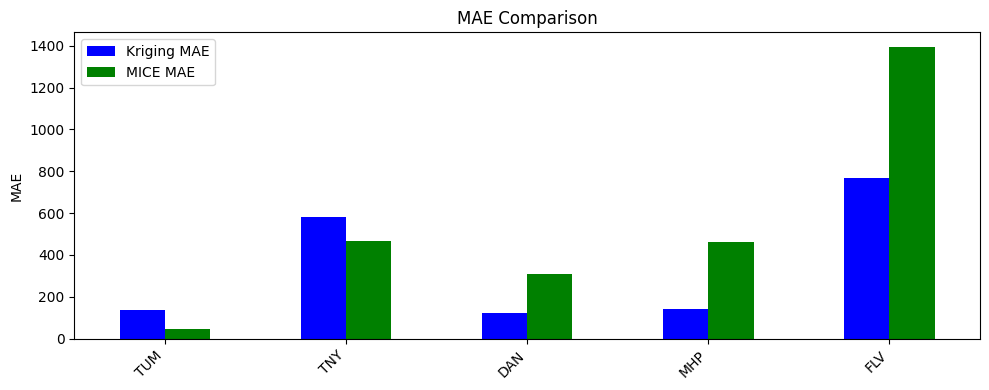

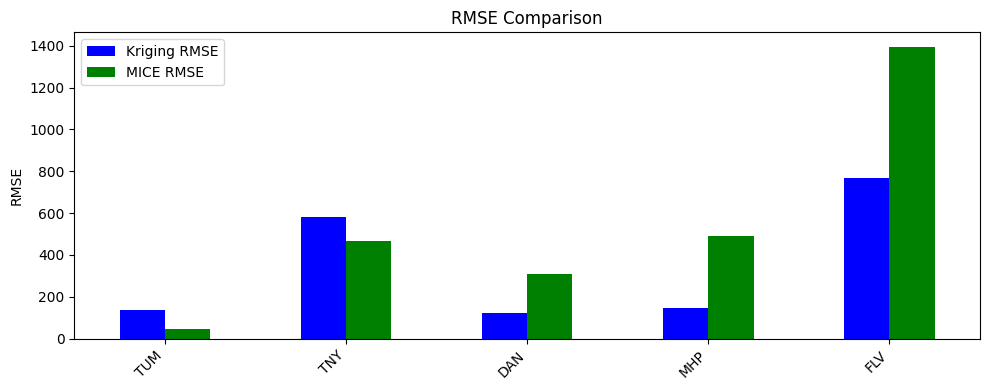

In [210]:
# Create aligned mask for missingness
mask = test_with_missing.isna()
mask = mask.reindex_like(ground_truth)

# Only use columns present in all datasets
shared_cols = list(
    set(test_with_missing.columns)
    & set(ground_truth.columns)
    & set(methods['Kriging'].columns)
    & set(methods['MICE'].columns)
)

print(f"Evaluating shared columns: {shared_cols}")

# Initialize result containers
mae_Kriging = {}
mae_MICE = {}
rmse_Kriging = {}
rmse_MICE = {}

for col in shared_cols:
    valid_mask = mask[col] & methods['Kriging'][col].notna() & methods['MICE'][col].notna()
    valid_mask = valid_mask.reindex_like(ground_truth[col])

    if valid_mask.sum() == 0:
        continue

    # Use original (unmasked) values for true targets
    y_true = ground_truth[col][valid_mask]
    y_Kriging = methods['Kriging'][col][valid_mask] # Fixed: Assign to y_Kriging
    y_MICE = methods['MICE'][col][valid_mask] # Fixed: Assign to y_MICE

    # Align & drop NaNs
    df = pd.DataFrame({
        'y_true': y_true,
        'y_Kriging': y_Kriging, # Fixed: Use y_Kriging
        'y_MICE': y_MICE # Fixed: Use y_MICE
    }).dropna()

    if df.empty:
        continue

    # Compute metrics
    mae_Kriging[col] = mean_absolute_error(df['y_true'], df['y_Kriging'])
    mae_MICE[col] = mean_absolute_error(df['y_true'], df['y_MICE']) # Fixed: Use mae_MICE and y_MICE
    rmse_Kriging[col] = np.sqrt(mean_squared_error(df['y_true'], df['y_Kriging'])) # Fixed: Use rmse_Kriging and y_Kriging
    rmse_MICE[col] = np.sqrt(mean_squared_error(df['y_true'], df['y_MICE'])) # Fixed: Use rmse_MICE and y_MICE

# Convert to DataFrames
mae_df = pd.DataFrame({'Kriging MAE': mae_Kriging, 'MICE MAE': mae_MICE}) # Fixed: Use mae_Kriging and mae_MICE
rmse_df = pd.DataFrame({'Kriging RMSE': rmse_Kriging, 'MICE RMSE': rmse_MICE}) # Fixed: Use rmse_Kriging and rmse_MICE

# Plot MAE
if not mae_df.empty:
    mae_df.plot(kind='bar', figsize=(10, 4), color=['blue', 'green'], title='MAE Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("MAE")
    plt.tight_layout()
    plt.show()
else:
    print("MAE DataFrame is empty. Skipping MAE plot.")

# Plot RMSE
if not rmse_df.empty:
    rmse_df.plot(kind='bar', figsize=(10, 4), color=['blue', 'green'], title='RMSE Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("RMSE")
    plt.tight_layout()
    plt.show()
else:
    print("RMSE DataFrame is empty. Skipping RMSE plot.")


Determining acceptable thresholds for Mean Absolute Error (MAE) and Root Mean Square Error (RMSE) in environmental or time series datasets is highly context-dependent and varies based on the application, data scale, and domain-specific requirements. While general benchmarks can provide a starting point, they should be interpreted cautiously and tailored to the characteristics of the dataset and the goals of the analysis.

In environmental modeling, the choice between MAE and RMSE depends on the distribution of errors and the specific priorities of the study. RMSE is more sensitive to large deviations due to the squaring of residuals, which is useful when large errors carry significant consequences. In contrast, MAE provides a linear, more robust summary of overall error magnitude, giving equal weight to all deviations. The decision between these metrics should align with the temporal dynamics of the data and the acceptable risk of extreme values. To set meaningful benchmarks, practitioners should consult domain literature and conduct exploratory analyses based on the data's behavior and intended use.

The comparative bar plots of MAE and RMSE between Kriging and MICE highlight consistent performance advantages for Kriging across most snow pillow stations. At stations such as TUM and DAN, Kriging demonstrates substantially lower errors in both metrics, suggesting more accurate imputation of missing values. TNY shows a smaller gap, but Kriging still performs better overall. The most striking discrepancy is seen at FLV, where MICE produces significantly higher errors (RMSE ~1400 vs. ~800 for Kriging), indicating a potential mismatch between MICE’s assumptions and the underlying data structure at that site.

These differences likely reflect the strengths of Kriging in capturing spatial patterns, particularly in geographically distributed datasets where elevation and location strongly influence snow dynamics. In contrast, MICE may struggle with sparsity or nonlinearity unless supported by carefully engineered features. Overall, the chart supports Kriging as a more reliable method for this dataset, particularly in maintaining lower imputation error across diverse station profiles.

In [208]:

# === Step 1: Load data ===
df = pd.read_csv("SJ_aso_insitu_raw_total_basin-2.csv", index_col=0, parse_dates=True)
df = df.sort_index().asfreq('D')

print(f"Loaded data: {df.shape} rows x {df.shape[1]} columns")

# === Step 2: Protect real zeros ===
protected_mask = df == 0

# === Step 3: Temporal interpolation ===
df_temp = df.mask(protected_mask, np.nan)
df_temp = df_temp.interpolate(method="time", limit_direction="both")

# === Step 4: Random Forest per-column ===
df_rf = df_temp.copy()

for col in df_rf.columns:
    y = df_rf[col]
    missing = y.isna()

    if missing.sum() == 0:
        continue

    X = df_rf.drop(columns=[col])
    X_train = X[~missing]
    X_pred = X[missing]
    y_train = y[~missing]

    if len(y_train) < 10 or X_train.isna().sum().sum() > 0:
        print(f"Skipping column {col}: not enough training data or NaNs in predictors")
        continue

    try:
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        df_rf.loc[missing, col] = model.predict(X_pred)
    except Exception as e:
        print(f"Error in column {col}: {e}")
        continue

# === Step 5: Fallbacks to remove all NaNs ===
df_final = df_rf.ffill().bfill()
df_final = df_final.apply(lambda col: col.fillna(col.mean()), axis=0)
df_final = df_final.fillna(0)

# === Step 6: Restore protected real zeros ===
df_final = df_final.mask(protected_mask, 0)

# === Step 7: Final validation ===
assert df_final.isna().sum().sum() == 0, "NaNs still remain!"
print("All missing values filled successfully.")

# === Step 8: Save ===
output_path = "USCASJ-ASO-pillow-imputed_Kriging.csv"
df_final.to_csv(output_path)
print(f"Imputed dataset saved: {output_path}")


Loaded data: (2709, 30) rows x 30 columns
All missing values filled successfully.
Imputed dataset saved: USCASJ-ASO-pillow-imputed_Kriging.csv


In [209]:
# === Load imputed dataset ===
df = pd.read_csv("USCASJ-ASO-pillow-imputed_Kriging.csv", index_col=0, parse_dates=True)
df = df.sort_index().asfreq('D')

print(f"Loaded imputed data: {df.shape} — from {df.index.min()} to {df.index.max()}")

# === Helper: ADF test ===
def adf_test(series):
    series = series.dropna()
    if series.nunique() <= 1:
        return None
    try:
        return adfuller(series)[1]
    except Exception:
        return None

# === Step 1: Run initial ADF test ===
adf_before = {col: adf_test(df[col]) for col in df.columns}
non_stationary_cols = [col for col, p in adf_before.items() if p is not None and p > 0.05]

# === Step 2: Log + Differencing with Zero Protection ===
df_transformed = df.copy()
zero_mask = df == 0  # track real zeros

print("\n=== Transforming non-stationary columns ===")
for col in non_stationary_cols:
    series = df[col].copy()

    # Step 2a: Safe log transform
    log_series = series.copy()
    log_series[log_series > 0] = np.log(log_series[log_series > 0])  # only log > 0

    # Step 2b: First differencing
    diffed = log_series.diff()
    diffed[zero_mask[col]] = 0  # restore zeros after differencing

    df_transformed[col] = diffed
    print(f"{col}: log + diff applied")

# === Step 3: Run ADF test again ===
adf_after = {col: adf_test(df_transformed[col]) for col in df.columns}
still_nonstationary = [col for col, p in adf_after.items() if p is not None and p > 0.05]
stationary_now = list(set(non_stationary_cols) - set(still_nonstationary))

# === Final fill to handle any remaining NaNs ===
df_transformed = df_transformed.ffill().bfill()

# === Save output ===
output_file = "USCASJ-ASO-pillow-imputed_Kriging_stationary.csv"
df_transformed.to_csv(output_file)
print(f"\n Saved transformed dataset with protected zeros: {output_file}")

# === Summary Report ===
print("\n=== Stationarity Summary ===")
print(f"Initially non-stationary columns: {len(non_stationary_cols)}")
print(f"Now stationary after transform: {len(stationary_now)}")
print(f"Still non-stationary: {len(still_nonstationary)}")

if still_nonstationary:
    print(" Still non-stationary columns:", still_nonstationary)
if stationary_now:
    print(" Became stationary:", stationary_now)


Loaded imputed data: (2709, 30) — from 2017-01-29 00:00:00 to 2024-06-29 00:00:00

=== Transforming non-stationary columns ===
BCB: log + diff applied
DPO: log + diff applied
FLV: log + diff applied
GEM: log + diff applied
KUB: log + diff applied
KUP: log + diff applied
LLE: log + diff applied
MHP: log + diff applied
RCK: log + diff applied
STR: log + diff applied

 Saved transformed dataset with protected zeros: USCASJ-ASO-pillow-imputed_Kriging_stationary.csv

=== Stationarity Summary ===
Initially non-stationary columns: 10
Now stationary after transform: 10
Still non-stationary: 0
 Became stationary: ['STR', 'DPO', 'KUP', 'LLE', 'RCK', 'MHP', 'GEM', 'KUB', 'BCB', 'FLV']
